# NIS uncertainty analysis using NEON BRDF flight

## Background

The NEON AOP has flown several special flight plans called BRDF (bi-directional reflectance distribution function) flights. These flights were designed to quantify the the effect of observing targets from a variety of different look-angles, and with varying surface roughness. This allows an assessment of the sensitivity of the NIS results to these paraemters. THe BRDF flight plan takes the form of a star pattern with repeating overlapping flight lines in each direction. In the center of the pattern is an area where nearly all the flight lines overlap. This area allows us to retrieve a reflectance curve of the same targat from the many different flight lines to visualize how then change for each acquisition. The following figures display a BRDF flight plan as well as the number of flightlines (samples) which are overlapping.  

![BRDF Flightlines](BRDF_flightlines.JPG)
![BRDF Flightlines Count](ORNL_NumberSamples.png)

To date, the NEON AOP has flown a BRDF flight at SJER and SOAP (D17) and ORNL (D07). We will work with the ORNL BRDF flight and retreive reflectance curves from up to 18 lines and compare them to visualize the differences in the resulting curves. To reduce the file size, each of the BRDF flight lines have been reduced to a rectangular area covering where all lines are overlapping, additionally several of the ancillary rasters normally included have been removed in order to reduce file size. 

## Objective

This lesson will cover opening NEON AOP HDF5 files with a function, batch processing several HDF5 files, relative comparison between several NIS observations of the same target from different view angles, error checking. 

## Recommended prerequisites

1) NEON AOP HDF5 Reflectance

2) Hyperspectral Functions and RGB Images

3) Plot SPectral Signature


We'll start off by again adding necessary libraries and our NEON AOP HDF5 reader function

In [10]:
import h5py
import csv
import numpy as np
import os
import gdal
import matplotlib.pyplot as plt
import sys
from math import floor
import time
import warnings
warnings.filterwarnings('ignore')

def h5refl2array(h5_filename):
    hdf5_file = h5py.File(h5_filename,'r')

    #Get the site name
    file_attrs_string = str(list(hdf5_file.items()))
    file_attrs_string_split = file_attrs_string.split("'")
    sitename = file_attrs_string_split[1]
    refl = hdf5_file[sitename]['Reflectance']
    reflArray = refl['Reflectance_Data']
    refl_shape = reflArray.shape
    wavelengths = refl['Metadata']['Spectral_Data']['Wavelength']
    #Create dictionary containing relevant metadata information
    metadata = {}
    metadata['shape'] = reflArray.shape
    metadata['mapInfo'] = refl['Metadata']['Coordinate_System']['Map_Info']
    #Extract no data value & set no data value to NaN\n",
    metadata['scaleFactor'] = float(reflArray.attrs['Scale_Factor'])
    metadata['noDataVal'] = float(reflArray.attrs['Data_Ignore_Value'])
    metadata['bad_band_window1'] = (refl.attrs['Band_Window_1_Nanometers'])
    metadata['bad_band_window2'] = (refl.attrs['Band_Window_2_Nanometers'])
    metadata['projection'] = refl['Metadata']['Coordinate_System']['Proj4'].value
    metadata['EPSG'] = int(refl['Metadata']['Coordinate_System']['EPSG Code'].value)
    mapInfo = refl['Metadata']['Coordinate_System']['Map_Info'].value
    mapInfo_string = str(mapInfo); #print('Map Info:',mapInfo_string)\n",
    mapInfo_split = mapInfo_string.split(",")
    #Extract the resolution & convert to floating decimal number
    metadata['res'] = {}
    metadata['res']['pixelWidth'] = mapInfo_split[5]
    metadata['res']['pixelHeight'] = mapInfo_split[6]
    #Extract the upper left-hand corner coordinates from mapInfo\n",
    xMin = float(mapInfo_split[3]) #convert from string to floating point number\n",
    yMax = float(mapInfo_split[4])
    #Calculate the xMax and yMin values from the dimensions\n",
    xMax = xMin + (refl_shape[1]*float(metadata['res']['pixelWidth'])) #xMax = left edge + (# of columns * resolution)\n",
    yMin = yMax - (refl_shape[0]*float(metadata['res']['pixelHeight'])) #yMin = top edge - (# of rows * resolution)\n",
    metadata['extent'] = (xMin,xMax,yMin,yMax),
    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = xMin
    metadata['ext_dict']['xMax'] = xMax
    metadata['ext_dict']['yMin'] = yMin
    metadata['ext_dict']['yMax'] = yMax
    hdf5_file.close        
    return reflArray, metadata, wavelengths

print('Starting BRDF Analysis')

Starting BRDF Analysis


First we will define the extents of the rectangular array containing the section from each BRDF flightline. 

In [11]:
BRDF_rectangle = np.array([[740315,3982265],[740928,3981839]],np.float)

Next we will define the coordinates of the target of interest. These can be set as any coordinate pait that falls within the rectangle above, therefore the coordaintes must be in UTM Zone 16 N.  

In [12]:
x_coord = 740600
y_coord = 3982000

To prevent the function of failing, we will first check to ensure the coordiantes are within the rectangular bounding box. If they are not, we throw an error message and exit from the script.

In [13]:
if BRDF_rectangle[0,0] <= x_coord <= BRDF_rectangle[1,0] and BRDF_rectangle[1,1] <= y_coord <= BRDF_rectangle[0,1]:
    print('Point in bounding area')
    y_index = floor(x_coord - BRDF_rectangle[0,0])
    x_index = floor(BRDF_rectangle[0,1] - y_coord)
else:
    print('Point not in bounding area, exiting')
    raise Exception('exit')

Point in bounding area


Now we will define the location of the all the subset NEON AOP h5 files from the BRDF flight

In [14]:
h5_directory = "C:/RSDI_2017/data/F07A/"

Now we will grab all files / folders within the defined directory and then cycle through them and retain only the h5files

In [15]:
files = os.listdir(h5_directory)
h5_files = [i for i in files if i.endswith('.h5')]

Now we will print the h5 files to make sure they have been included and set up a figure for plotting all of the reflectance curves

In [16]:
print(h5_files)

fig=plt.figure()
ax = plt.subplot(111)

['NEON_D07_F07A_DP1_20160611_160444_reflectance_modify.h5', 'NEON_D07_F07A_DP1_20160611_160846_reflectance_modify.h5', 'NEON_D07_F07A_DP1_20160611_161228_reflectance_modify.h5', 'NEON_D07_F07A_DP1_20160611_161532_reflectance_modify.h5', 'NEON_D07_F07A_DP1_20160611_162007_reflectance_modify.h5', 'NEON_D07_F07A_DP1_20160611_162514_reflectance_modify.h5', 'NEON_D07_F07A_DP1_20160611_162951_reflectance_modify.h5', 'NEON_D07_F07A_DP1_20160611_163424_reflectance_modify.h5', 'NEON_D07_F07A_DP1_20160611_163945_reflectance_modify.h5', 'NEON_D07_F07A_DP1_20160611_164259_reflectance_modify.h5', 'NEON_D07_F07A_DP1_20160611_164809_reflectance_modify.h5', 'NEON_D07_F07A_DP1_20160611_165240_reflectance_modify.h5', 'NEON_D07_F07A_DP1_20160611_165711_reflectance_modify.h5', 'NEON_D07_F07A_DP1_20160611_170118_reflectance_modify.h5', 'NEON_D07_F07A_DP1_20160611_170538_reflectance_modify.h5', 'NEON_D07_F07A_DP1_20160611_170922_reflectance_modify.h5', 'NEON_D07_F07A_DP1_20160611_171403_reflectance_modify.h

Now we will begin cycling through all of the h5 files and retreiving the information we need also print the file that is currently being processed

Inside the for loop we will

1) read in the reflectance data and the associated metadata, but construct the file name from the generated file list

2) Determine the indexes of the water vapor bands (bad band windows) in order to mask out all of the bad bands

3) Read in the reflectance dataset using the NEON AOP H5 reader function

4) Check the first value the first value of the reflectance curve (actually any value). If it is equivalent to the NO DATA value, then coordainte chosen did not intersect a pixel for the flight line. We will just continue and move to the next line.

5) Apply NaN values to the areas contianing the bad bands

6) Split the contents of the file name so we can get the line number for labelling in the plot.

7) Plot the curve



In [17]:
for file in h5_files:

    print('Working on ' + file)
    
    [reflArray,metadata,wavelengths] = h5refl2array(h5_directory+file)
    bad_band_window1 = (metadata['bad_band_window1'])
    bad_band_window2 = (metadata['bad_band_window2'])

    index_bad_window1 = [i for i, x in enumerate(wavelengths) if x > bad_band_window1[0] and x < bad_band_window1[1]]
    index_bad_window2 = [i for i, x in enumerate(wavelengths) if x > bad_band_window2[0] and x < bad_band_window2[1]]
    
    index_bad_windows = index_bad_window1+index_bad_window2
    reflectance_curve = np.asarray(reflArray[y_index,x_index,:], dtype=np.float32)
    if reflectance_curve[0] == metadata['noDataVal']:
        continue
    reflectance_curve[index_bad_windows] = np.nan
    filename_split = (file).split("_") 
    ax.plot(wavelengths,reflectance_curve/metadata['scaleFactor'],label = filename_split[5]+' Reflectance')

Working on NEON_D07_F07A_DP1_20160611_160444_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_160846_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_161228_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_161532_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_162007_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_162514_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_162951_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_163424_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_163945_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_164259_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_164809_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_165240_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_165711_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_170118_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_170538_reflectance_modif

This plots the reflectance curves from all lines onto the same plot. Now, we will add the appropriate legend and plot labels, display and save the plot with the coordaintes in the file name so we can repeat the position of the target

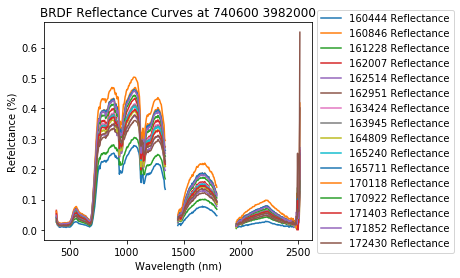

In [18]:
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left',bbox_to_anchor=(1,0.5))
plt.title('BRDF Reflectance Curves at ' + str(x_coord) +' '+ str(y_coord))
plt.xlabel('Wavelength (nm)'); plt.ylabel('Refelctance (%)')
fig.savefig('BRDF_uncertainty_at_' + str(x_coord) +'_'+ str(y_coord)+'.png',dpi=500,orientation='landscape',bbox_inches='tight',pad_inches=0.1)
plt.show()

The result is a plot with all the curves in which we can visualize the difference in the observations simply by chaging the flight direction with repect to the ground target.

Experiment with changing the coordiante to analyze different targets within the rectangle.

